In [ ]:
using JuMP
using Ipopt
using DataFrames
import XLSX

In [ ]:
#These two are interdependent in the model and can be included in the future
a1 = 1/3.4e7 # proportion of migrating squid, where 3.4E7 max(e^(tau-b1))
K = 1208770.0 # carrying capacity in t
# These are the only real constants
f = 40.0 # l of fuel per trip
B_h = 7.203 # hours per fisher
B_f = 2.0 # fisher per panga
m = 5492603.58 # cost per unit of transport all boats, MXN/trip
c_t = m*f # fleet cost of transport

### Initial values #############################################################
tau0 = 42.0 # temperature
q0 = 0.01 # squid catchability
y_S0 = 0.5 # proportion of migrated squid
R_tt0 = 0.5 # trader cooperation
S0 = 1208770.0 # size of the squid population
E0 = 1.0 # fishing effort
C0 = 120877.0 # squid catch
p_e0 = 164706.0 # max p_e comtrade
p_f0 = 15438.0 # max p_f datamares
R0 = C0*p_f0-(c_t+E0);

In [ ]:
#df2 looks at 2001-2016, so df1 should only yield that set too
df1 = DataFrame(XLSX.readtable("./DATA/R3_data.xlsx", "Sheet1")...)
# load columns
y = Int64.(df1[:year][11:26]) #
#pe = Float64.(map(x->ismissing(x) ? NaN : x, df1[:pe_MXNiat][11:26])) #
pf = Float64.(df1[:pf_MXNiat][11:26]) #
#ct = Float64.(map(x->ismissing(x) ? NaN : x, df1[:C_t][11:26])) #
#ssh = Float64.(map(x->ismissing(x) ? NaN : x, df1[:essh_avg][11:26])) #
ml = Float64.(df1[:ML][11:26]) #
ys = map(x->parse(Float64,x),df1[:y_S][11:26]) #


df2 = dropmissing(DataFrame(XLSX.readtable("./DATA/PriceVolDataCorrected.xlsx", "Sheet1")...))
VolAll = Float64.(df2[:tons_DM]) ## CATCH DATA
PrAll = Float64.(df2[:priceMXNia_DM]) ## PRICE DATA 

### New max time
tmax = length(df2[:Year]);

In [ ]:
model = JuMP.Model(solver = IpoptSolver(print_level=3, max_iter=99900,print_frequency_iter=50,sb="yes"));

- ~~We can probably add in migration costs rather than fixed costs (`c_t`).~~
- `a1` seems to be conditional on `max(tau)`...
- ~~`cachability` is too hardcoded for my liking~~
- ~~Why is `y_S` confined on [0,1]?~~
- `p_f[1]` is *not* defined as `PrAll[1]` (as with `C[1]`). Why not?

In [ ]:
@variable(model, 38.750 <= b1 <= 42.1, start = 41.750) # isotherm depth (est)
@variable(model, -6.9 <= b2 <= -3.987, start = -5.696) # isotherm depth (est)
@variable(model, 11.478 <= b3 <= 16.4, start = 16.397) # isotherm depth (est)
@variable(model, 0.0 <= beta <= 1.0, start = 0.0736) # slope of demand-price function
@variable(model, 1000.0 <= c_p <= 2148.0, start = 1776.25) # cost of processing, MXNia/t
@variable(model, 0.0 <= g <= 3.2, start = 1.4) # population growth rate
@variable(model, 20000.0 <= gamma <= 51000.0, start = 49200.0) # maximum demand, t
@variable(model, 11956952.0 <= w_m <= 28108539.0, start = 13355164.0) # min wage per hour all fleet
@variable(model, h1, start = 2e-10) # E scale
@variable(model, h2, start = 0.6596) # E scale
@variable(model, l1, start = -0.0028) # q scale
@variable(model, l2, start = 0.1667) # q scale

@variable(model, 20.0 <= tau[t=1:tmax] <= 80.0) # temperature
@variable(model, 4000.0 <= p_e[t=1:tmax] <= 100_000.0) # export price
@variable(model, q[t=1:tmax]) # catchability squid population
@variable(model, 0.0 <= y_S[t=1:tmax] <= 1.0) # Proportion of squid migration from initial fishing grounds
@variable(model, R_tt[t=1:tmax]) # trader cooperation
@variable(model, p_min[t=1:tmax] >= 0.0) # minimum wage 28_000_000
# c_t is per trip so we need to upscale E hr > fisher > trip
@variable(model, Escal[t=1:tmax]) # fishing effort
@variable(model, 0.0 <= E[t=1:tmax] <= 1.0) # fishing effort
@variable(model, S[t=1:tmax] >= 0.0) # size of the squid population 18000 , 1200000
@variable(model, C[t=1:tmax]  >= 0.0) # squid catch 10% of S
@variable(model, p_f[t=1:tmax]) # price for fishers

@variable(model, data[t=1:tmax])
@variable(model, match)

@constraint(model, [t=1:tmax], tau[t] == b1+b2*cos.(t)+b3*sin.(t));
@NLconstraint(model, [t=1:tmax], p_e[t] == gamma*(C[t])^(-beta));
@NLconstraint(model, [t=1:tmax-1], Escal[t+1] == E[t]+p_f[t]*q[t]*E[t]*S[t]-c_t*(E[t]/(B_h+B_f)));
@constraint(model, [t=1:tmax], E[t] == h1*Escal[t]+h2);
@constraint(model, [t=1:tmax], R_tt[t] == 1-y_S[t]);
@NLconstraint(model, [t=1:tmax-1], S[t+1] == S[t]+g*S[t]*(1-(S[t]/K))-q[t]*E[t]*S[t]);
@NLconstraint(model, [t=1:tmax], C[t] == q[t]*E[t]*S[t]);
@NLconstraint(model, [t=1:tmax], p_min[t] == (E[t]*w_m)/C[t]);
@constraint(model, [t=1:tmax], p_f[t] == (p_e[t]-c_p)*(1-R_tt[t])+R_tt[t]*p_min[t]);
@NLconstraint(model, [t=1:tmax], y_S[t] == a1*exp(tau[t]-b1));
@constraint(model, [t=1:tmax], q[t] == l1*tau[t]+l2);
#@constraint(model, [t=1:tmax-1], R[t+1] == C[t+1]*p_f[t+1]-c_t*(E[t]/(B_h+B_f)));

# Input data
@constraint(model, data[t=1:tmax] .== PrAll[t]);

# Initial conditions
@constraint(model, tau[1] == tau0);  # temperature
@constraint(model, p_f[1] == p_f0); # max p_f datamares
@constraint(model, p_e[1] == p_e0); # max p_e comtrade
@constraint(model, y_S[1] == y_S0); # proportion of migrated squid
@constraint(model, R_tt[1] == R_tt0); # trader cooperation
@constraint(model, C[1] == C0); # squid catch
@constraint(model, q[1] == q0); # squid catchability
@constraint(model, E[1] == E0); # fishing effort
@constraint(model, S[1] == S0); # size of the squid population

#Minimise ther differences between our model and the data
#NOTE: Fig1 only currently, fig 2 matches volume `C`
@NLconstraint(model, match == sum(abs(p_f[t] - data[t]) for t in 1:tmax));
@NLobjective(model, Min, match);

In [ ]:
solve(model)

**TODO:** `ML` and `R` have been removed from the model but ultimately are required outputs.
They should be post-processed vectors.

In [ ]:
using Plots

In [ ]:
plot(y, pf)

In [3]:
using LsqFit
using Plots

In [4]:
modpf(t,p) = p[1]*t.^(-p[2])-p[3]

modpf (generic function with 1 method)

In [5]:
xdata = 1:16
p0 = [30000.0, 0.1, 1500.0]

3-element Array{Float64,1}:
 30000.0
     0.1
  1500.0

In [11]:
fit = curve_fit(modpf, VolAll, PrAll, p0)

LsqFit.LsqFitResult{Float64,1}(13, [81126.8, 0.0505775, 43050.7], [794.067, -639.241, 420.463, 60.2963, 1029.53, 1190.16, 628.803, 598.799, 1541.71, -419.208, -673.878, 511.736, -2300.15, -3751.61, 2685.36, -1656.49], [0.577242 -5.08777e5 -1.0; 0.562989 -5.18793e5 -1.0; … ; 0.688845 -4.11845e5 -1.0; 0.700535 -399925.0 -1.0], false, Float64[])

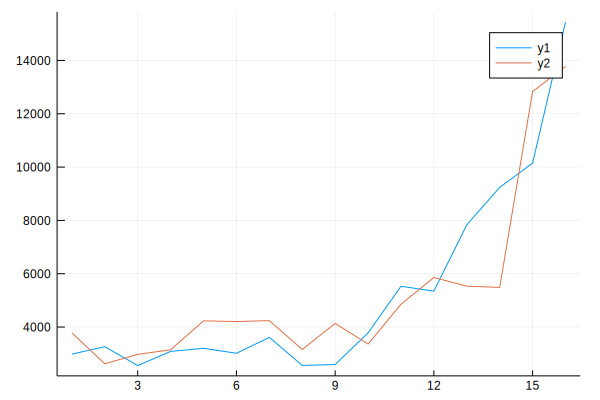

In [13]:
plot(PrAll)
plot!(modpf(VolAll,fit.param))

In [16]:
fit.param

3-element Array{Float64,1}:
 81126.8      
     0.0505775
 43050.7      